In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, spearmanr
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [94]:
# Set the path to the file you'd like to load
file_path = "weekly_player_stats_offense.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)

import requests

# Years you want to pull
years = range(2016, 2024)  # Adjust as needed
all_adp = []

for y in years:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        # Each player entry is in data["players"]
        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

# Combine all into one DataFrame
adp_all = pd.concat(all_adp, ignore_index=True)

# Optional: clean player names
adp_all["name"] = adp_all["name"].str.strip()

# Preview
print(adp_all.head())

# Save to JSON if you want a file
adp_all.to_json("historical_adp_ppr.json", orient="records")

# --- Step 1: pick only the columns you want from ADP ---
# Example: name, position, team, average ADP, and season
# --- Step 1: pick only needed columns ---
adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

# --- Step 2: normalize player names for matching ---
adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 3: average ADP per player-season ---
# If there are multiple ADP rows for the same player/season, this averages them
adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",          # average the ADP values
        }))

# --- Step 4: prep your main DF for merge ---
df["player_name_merge"] = (
    df["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 5: merge the averaged ADP into your stats ---
df= df.merge(adp_all, on=["season", "player_name_merge"], how="left")

# --- Step 6: check result ---
print(df[["player_name", "season", "adp", "position", "team"]].head())

/tmp/ipython-input-3212445234.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


2016 — 188 players loaded
2017 — 184 players loaded
2018 — 197 players loaded
2019 — 200 players loaded
2020 — 203 players loaded
2021 — 211 players loaded
2022 — 157 players loaded
2023 — 202 players loaded
   player_id               name position team  adp adp_formatted  \
0       1886      Antonio Brown       WR  PIT  1.2          1.01   
1       1796        Julio Jones       WR  ATL  2.8          1.03   
2       2113  Odell Beckham Jr.       WR  NYG  3.4          1.03   
3       2297      David Johnson       RB  ARI  3.4          1.03   
4       2280        Todd Gurley       RB  LAR  6.3          1.06   

   times_drafted  high  low  stdev  bye  season  
0            454     1    4    0.5    5    2016  
1            348     1    6    0.9    5    2016  
2            512     1   10    1.2   14    2016  
3            146     1    7    1.5    8    2016  
4            470     1   12    1.8    8    2016  
     player_name  season  adp position team
0  Charlie Batch    2012  NaN       QB 

In [95]:
df=df[df["season"]>=2016]
df=df[df["season"]<=2022]
print(df["adp"])

15557    68.5
15558    68.5
15559    68.5
15560    68.5
15561    68.5
         ... 
48545     NaN
48546     NaN
48547     NaN
48548     NaN
48549     NaN
Name: adp, Length: 32993, dtype: float64


0 count    832.000000
mean       7.845383
std        5.022206
min       -2.000000
25%        3.858239
50%        7.044524
75%       11.045588
max       26.135000
Name: fantasy_points_ppr, dtype: float64
Train R²: 0.702
Test R²: 0.573
Cross-validated R² scores: [0.57105291 0.57056536 0.5267165  0.45501437 0.63692787]
Mean CV R²: 0.552


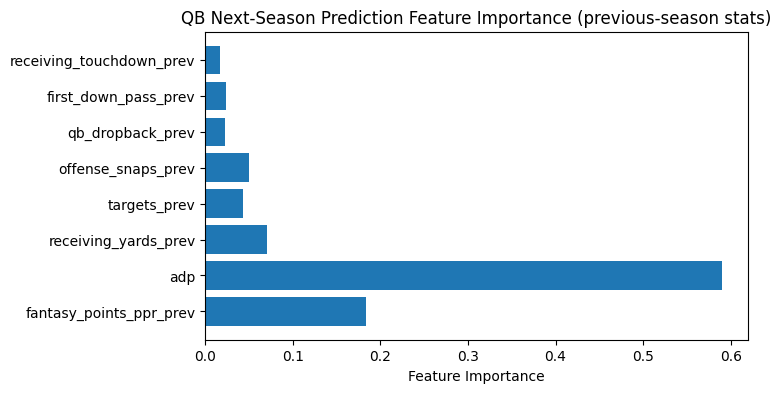


Top predictions (sorted by predicted value):
      player_id            player_name  season  target_season_actual  \
699  00-0035246  J.J. Arcega-Whiteside    2021              1.200000   
443  00-0033060          Leonte Carroo    2017              2.475000   
490  00-0033464           Jehu Chesson    2018              0.650000   
739  00-0035645       Gunner Olszewski    2021              1.500000   
728  00-0035593         Juwann Winfree    2022              2.700000   
408  00-0032881         Tommylee Lewis    2018              0.800000   
218  00-0031319        Diontae Spencer    2021              0.175000   
353  00-0032362         Maurice Harris    2017              1.600000   
197  00-0031060      De'Anthony Thomas    2019              0.250000   
564  00-0033933          Chad Williams    2018              3.922222   
35   00-0027654         Arrelious Benn    2017              1.100000   
297  00-0031787           Jake Kumerow    2022              2.600000   
385  00-0032724   

In [96]:
# Predict next-season QB performance using previous-season stats
# Uses the same column names referenced in your clipboarded code.
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# df is assumed to already exist and contain your raw play/week-level data
# Keep only QBs and required dtypes (adapted from your clipboard)
# Use 'position' from the merged dataframe
df = df[df['position'] == 'WR'].copy()

df['week'] = df['week'].astype(int)
df['season'] = df['season'].astype(int)
df["adp"]=df["adp"].replace(0,10000)
# ensure fantasy column is float if present
# Use the appropriate fantasy points column from the merged dataframe (likely 'fantasy_points_ppr' or 'season_average_fantasy_points_ppr')
# Let's assume 'fantasy_points_ppr' is the one from the original stats data
if 'fantasy_points_ppr' in df.columns:
    df['fantasy_points_ppr'] = df['fantasy_points_ppr'].astype(float)
    fantasy_points_col = 'fantasy_points_ppr'
elif 'season_average_fantasy_points_ppr' in df.columns:
     df['season_average_fantasy_points_ppr'] = df['season_average_fantasy_points_ppr'].astype(float)
     fantasy_points_col = 'season_average_fantasy_points_ppr'
else:
    raise KeyError("No suitable fantasy points column found in the dataframe.")


# 1) Aggregate season-level numeric stats per player-season (season totals / means as appropriate)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
# keep player_id, player_name, season for grouping
group_cols = ['player_id', 'season']
# Remove 'season' and 'adp' from the columns to be aggregated with sum
agg_cols = {c: 'sum' for c in numeric_cols if c not in group_cols and c != "fantasy_points_ppr" and c != "draft_round" and c != "age"}
# Add adp with 'mean' aggregation
agg_cols['fantasy_points_ppr'] = 'mean'
agg_cols['draft_round'] = 'first'
agg_cols['age'] = 'first'


season_agg = df.groupby(group_cols).agg(
    agg_cols
).reset_index() # season is now correctly a column after reset_index


# Optionally also keep player_name (first occurrence)
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    # Merge on group_cols after reset_index
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


# 2) Build previous-season features -> next-season target
# shift season by +1 to align previous season stats with the following season target
prev = season_agg.copy()
prev['season'] = prev['season'] + 1
# suffix previous-season feature names with _prev so they are explicit
prev = prev.add_suffix('_prev')
# fix column names for join: player_id_prev and season_prev exist; we will join on those matching current season
# prepare current-season frame (target season)
curr = season_agg.copy()
# Merge prev (previous-season stats) onto curr (current season) using player_id and season
merged_prev_next = curr.merge(
    prev,
    left_on=['player_id', 'season'],
    right_on=['player_id_prev', 'season_prev'],
    how='inner'  # inner join ensures we only keep seasons where previous season data exists
)

# 3) Choose features and target using same column names where possible
# Example feature columns (from your clipboard): passing_yards, fantasy_points_ppr, qb_dropback, team_offense_snaps, first_down_pass, adp
# We expect these to exist as numeric season aggregates in season_agg; adjust if your column names differ.
# Use the appropriate column names from the merged dataframe


# Create list of features from the previous-season suffixed columns
features = [      'fantasy_points_ppr_prev', 'adp',
            "receiving_yards_prev","targets_prev","offense_snaps_prev","qb_dropback_prev",
            "first_down_pass_prev",
            "receiving_touchdown_prev"
]

# Define target as the current season's season_average_fantasy_points_ppr if available,
# otherwise fall back to the aggregated fantasy points column.
# Use the appropriate target column from the merged dataframe
if 'fantasy_points_ppr' in merged_prev_next.columns:
    target = 'fantasy_points_ppr'
elif fantasy_points_col in merged_prev_next.columns:
    target = fantasy_points_col
else:
    raise KeyError("No suitable target column found in the merged dataframe.")


# Drop rows with NaNs in features/target
model_df = merged_prev_next.dropna(subset=features + [target]).copy()
# Basic train/test split
X = model_df[features]
X = X.replace(0, 10000)

y = model_df[target]
identifiers = model_df[['player_id', 'season', 'player_name']] if 'player_name' in model_df.columns else model_df[['player_id', 'season']]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, identifiers.index, test_size=0.3, random_state=42
)

# 4) Model (RandomForestRegressor with overfitting control like your clipboard)
model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
)
print(y.isna().sum(), y.describe())

model.fit(X_train, y_train)

# Evaluate
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

# Cross-validation on full dataset
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

# Feature importance plot
importances = model.feature_importances_
plt.figure(figsize=(7, max(3, len(features) * 0.5)))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()

# 5) Generate predictions and results table (predicting current season using previous-season stats)
preds = model.predict(X)
results = pd.DataFrame({
    'player_id': identifiers.loc[X.index, 'player_id'],
    'player_name': identifiers.loc[X.index, 'player_name'] if 'player_name' in identifiers.columns else np.nan,
    'season': identifiers.loc[X.index, 'season'],
    'target_season_actual': y,
    'predicted_from_prev_season': preds,
    'error': y - preds,
    'adp': model_df['adp']
}, index=X.index)

# show top results by predicted value
print("\nTop predictions (sorted by predicted value):")
print(results.sort_values('predicted_from_prev_season', ascending=True).head(15))

# Optional: export results
# results.to_csv("qb_next_season_predictions_from_prev.csv", index=False)

In [97]:
# Rank players by ADP (lower ADP = better rank)
results["adp"]=results["adp"].replace(0,np.inf)
results["adp_rank"] = results.groupby("season")["adp"].rank(method="min", ascending=True)

# Rank players by predicted performance (higher predicted points = better rank)
results["predicted_rank"] = results.groupby("season")["predicted_from_prev_season"] \
                                   .rank(method="min", ascending=False)

# Optional: difference between how your model ranks them and how the market ranked them
results["rank_diff"] = results["predicted_rank"] - results["adp_rank"]

# Now you can sort by rank_diff to find biggest sleepers / overvalued players
print(results.sort_values(["season", "rank_diff"],ascending=False).head(15))


      player_id           player_name  season  target_season_actual  \
728  00-0035593        Juwann Winfree    2022              2.700000   
297  00-0031787          Jake Kumerow    2022              2.600000   
813  00-0036620      D'Wayne Eskridge    2022              1.725000   
815  00-0036630         Tylan Wallace    2022              1.275000   
684  00-0035022            Penny Hart    2022              1.250000   
820  00-0036877         Jaelon Darden    2022              1.600000   
740  00-0035645      Gunner Olszewski    2022              1.420000   
808  00-0036482         Mike Strachan    2022              1.780000   
707  00-0035399        Stanley Morgan    2022              0.000000   
811  00-0036572             Shi Smith    2022              3.640000   
818  00-0036671             Dax Milne    2022              2.242857   
804  00-0036412           K.J. Hamler    2022              3.966667   
816  00-0036635  Ihmir Smith-Marsette    2022             -0.200000   
725  0

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Assume df is already loaded and filtered for QBs from 2016-2022 (as per cell T9WZ8koDR4Yp)
# The variable 'df' in this cell should be the filtered QB dataframe.
# To ensure this, let's explicitly filter 'df' again for clarity, though it might be redundant if T9WZ8koDR4Yp ran just before.
# If running this cell independently, you might need to re-run cell T9WZ8koDR4Yp first to get the correct 'df'.

# Let's assume df is the QB dataframe from 2016-2022
# df = df[(df['season'] >= 2016) & (df['season'] <= 2022)].copy() # This should have been done upstream
# df = df[df['position'] == 'QB'].copy() # This should have been done upstream

# 1) Aggregate season-level numeric stats per player-season
# Group by player_id and season, and sum numeric columns.
# 'season' is included in the groupby key, so it will become part of the index.
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
group_cols = ['player_id', 'season']

# Create aggregation dictionary, excluding the grouping columns from the sum list
agg_dict = {c: 'sum' for c in numeric_cols if c not in group_cols and c != "fantasy_points_ppr"}
# Add adp with 'mean' aggregation
agg_dict['fantasy_points_ppr'] = 'mean'
season_agg = df.groupby(group_cols).agg(agg_dict).reset_index()

# Optionally also keep player_name (first occurrence)
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


# 2) Build previous-season features -> next-season target
# Prepare previous-season feature: use previous season's fantasy points
# Determine which fantasy column to use as the feature and target
feat_col = None
target_col = None

# First, let's make sure the necessary columns exist in season_agg after aggregation
# Note: 'fantasy_points_ppr' or 'season_average_fantasy_points_ppr'
# should ideally come from the aggregation or be merged subsequently.
# Based on cell T9WZ8koDR4Yp, 'fantasy_points_ppr' seems to be an aggregated column.
# 'season_average_fantasy_points_ppr' might also be available or calculated.

# Let's check which columns are available in season_agg for fantasy points
available_fantasy_cols = [col for col in ['fantasy_points_ppr'] if col in season_agg.columns]

if not available_fantasy_cols:
    raise KeyError("Missing required fantasy columns ('fantasy_points_ppr' or 'season_average_fantasy_points_ppr') in aggregated data.")

# Use the first available fantasy column for both feature and target for this baseline model
# If season_average_fantasy_points_ppr exists, use it for the target. Otherwise use fantasy_points_ppr
target_col = "fantasy_points_ppr"
    # Use fantasy_points_ppr for the feature if available, otherwise use the target_col
feat_col = 'adp'


prev = season_agg.copy()
prev['season'] = prev['season'] + 1
# Rename the feature column with _prev suffix
if feat_col in prev.columns:
    prev = prev[['player_id', 'season', feat_col]].rename(columns={feat_col: feat_col + '_prev'})
else:
     raise KeyError(f"Feature column '{feat_col}' not found in previous season data.")


curr = season_agg.copy()
# Merge prev (previous-season stats) onto curr (current season) using player_id and season
merged_baseline = curr.merge(prev, on=['player_id', 'season'], how='inner')

# Keep only rows without NaNs in feature/target
merged_baseline = merged_baseline.dropna(subset=[feat_col + '_prev', target_col]).copy()

# Baseline feature matrix and target
X = merged_baseline[[feat_col]].values  # single-feature baseline
y = merged_baseline[target_col].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model: simple linear regression baseline
baseline_model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=6,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")
# Need to import mean_absolute_error if not already imported
# from sklearn.metrics import mean_absolute_error
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")

# Cross-validated R²
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

# Results dataframe with player info and errors
# Ensure columns used exist in merged_baseline
results = pd.DataFrame({
    'player_id': merged_baseline['player_id'],
    'player_name': merged_baseline['player_name'] if 'player_name' in merged_baseline.columns else np.nan,
    'season': merged_baseline['season'],
    'adp': merged_baseline[feat_col],
    'actual_target_season': merged_baseline[target_col],
    'predicted_target_season': baseline_model.predict(merged_baseline[[feat_col]].values)
})

results['error'] = results['actual_target_season'] - results['predicted_target_season']

# Show top 10 by prev_season_fantasy
print("\nBaseline predictions (top by previous-season fantasy):")
print(results.sort_values("adp", ascending=False).head(10))


Train R²: 0.550
Test R²: 0.555
Test MAE: 2.744
Cross-validated R² scores: [0.55779149 0.48296685 0.51845306 0.39443302 0.53651318]
Mean CV R²: 0.498

Baseline predictions (top by previous-season fantasy):
      player_id               player_name  season     adp  \
382  00-0032688             Robbie Chosen    2020  2622.4   
583  00-0034272  Marquez Valdes-Scantling    2022  2580.0   
344  00-0032211             Tyler Lockett    2017  2497.6   
468  00-0033282             Curtis Samuel    2020  2458.5   
122  00-0029632              Mohamed Sanu    2017  2443.5   
528  00-0033839            Dede Westbrook    2018  2443.2   
495  00-0033466           Isaiah McKenzie    2022  2441.6   
387  00-0032760              Josh Doctson    2018  2434.5   
96   00-0029000              Cole Beasley    2021  2414.4   
124  00-0029632              Mohamed Sanu    2019  2410.5   

     actual_target_season  predicted_target_season     error  
382             13.550000                 9.281436  4.268564

In [99]:
import pandas as pd
import requests
from kagglehub import load_dataset, KaggleDatasetAdapter

# --- Load base stats ---
file_path = "weekly_player_stats_offense.csv"
df_real = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "philiphyde1/nfl-stats-1999-2022",
    file_path,
)

# Use 2024 stats as prior season and label as 2025
df_real = df_real[df_real["season"] == 2024].copy()
df_real["season"] = 2025
df_real=df_real[df_real["position"]=="WR"]
# --- Pull ADP data ---
years = 2025
years_list = [years] if isinstance(years, int) else list(years)
all_adp = []

for y in years_list:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    r = requests.get(url)
    r.raise_for_status()
    df_adp = pd.DataFrame(r.json()["players"])
    df_adp["season"] = y
    all_adp.append(df_adp)
    print(f"{y} — {len(df_adp)} players loaded")

adp_all = pd.concat(all_adp, ignore_index=True)
adp_all["name"] = adp_all["name"].str.strip()

# Keep needed cols
adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()
adp_keep=adp_keep[adp_keep["position"]=="WR"]

# Name normalization
def normalize_name(s: pd.Series) -> pd.Series:
    return (
        s.fillna("")
         .str.strip()
         .str.replace(r"\s+Jr\.?$", "", regex=True)
         .str.replace(r"\s+Sr\.?$", "", regex=True)
         .str.replace(r"\s+III?$", "", regex=True)
         .str.replace(r"[^\w\s\-']", "", regex=True)
         .str.replace(r"\s+", " ", regex=True)
    )

adp_keep["player_name_merge"] = normalize_name(adp_keep["name"])
df_real["player_name_merge"] = normalize_name(df_real["player_name"])

# --- Non-summed ADP (representative value) ---
adp_non_sum = (
    adp_keep
    .groupby(["season", "player_name_merge",] ,as_index=False)
    .agg({
        "adp": "first",
       }))


# Merge both into df_real
df_real = df_real.merge(adp_non_sum, on=["season", "player_name_merge"], how="outer")

# --- Build RB aggregate without re-summing ADP columns ---
rb = df_real[df_real["position"] == "WR"].copy()

# Sum only numeric stat columns EXCEPT the ADP fields
num_cols = rb.select_dtypes(include="number").columns.tolist()

RB_stats = (
    rb.groupby(["player_name", "season"], as_index=False)[num_cols]
      .sum()
)

# Bring in exactly one row of ADP fields per player-season
RB_adps = (
    rb.groupby(["player_name", "season"], as_index=False)
      .agg({"adp": "first", "position": "first", "team": "first"})  # pick fields you want
)


RB_2025 = RB_stats.merge(RB_adps, on=["player_name", "season"], how="left")

# --- Rename stats to *_prev if present ---
adp_non_sum.rename(columns={"adp": "adp_for_rank",
                            "player_name_merge":"player_name"}, inplace=True)

# --- Preview ---
print(RB_stats[["player_name",  "adp"]]
      .sort_values("adp", ascending=False)
      .head(15))
rename_map = {
      "passing_yards": "passing_yards_prev",
    "fantasy_points_ppr": "fantasy_points_ppr_prev",
    "rushing_yards": "rushing_yards_prev",
    "pass_touchdown": "pass_touchdown_prev",
    "qb_dropback": "qb_dropback_prev",
    "first_down_pass": "first_down_pass_prev",
    "team_offense_snaps": "team_offense_snaps_prev",
    "touches": "touches_prev",
    "receiving_yards": "receiving_yards_prev",
    "targets": "targets_prev",
    "offense_snaps": "offense_snaps_prev",
    "receiving_touchdown": "receiving_touchdown_prev",
}
RB_2025 = RB_stats.rename(columns={k: v for k, v in rename_map.items() if k in RB_2025.columns})
RB_2025=RB_2025.replace(0,10000)
print(adp_non_sum.columns)
RB_2025["predicted_target_season"] = model.predict(RB_2025[features].values)
adp_non_sum=adp_non_sum.replace(0,10000)
X_input = RB_2025[features]

print("NaN count per feature:\n", X_input.isna().sum())
print("Any inf?", np.isinf(X_input.to_numpy()).any())



/tmp/ipython-input-4063197044.py:7: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_real = load_dataset(


2025 — 243 players loaded
           player_name     adp
4          Alec Pierce  3041.6
47     DeAndre Hopkins  2998.8
166      Tyler Lockett  2873.0
21       Calvin Austin  2862.8
42      Darius Slayton  2838.4
121     Michael Wilson  2641.6
132   Quentin Johnston  2476.5
174     Xavier Legette  2316.0
136     Rashod Bateman  2281.4
171  Wan'Dale Robinson  2191.3
72      Jalen McMillan  2173.6
118        Marvin Mims  2065.6
141        Romeo Doubs  1726.8
101       Keenan Allen  1722.0
43      Darnell Mooney  1641.6
Index(['season', 'player_name', 'adp_for_rank'], dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


NaN count per feature:
 fantasy_points_ppr_prev     0
adp                         0
receiving_yards_prev        0
targets_prev                0
offense_snaps_prev          0
qb_dropback_prev            0
first_down_pass_prev        0
receiving_touchdown_prev    0
dtype: int64
Any inf? False


In [100]:
print(RB_2025)

           player_name  season   week  offense_snaps_prev  offense_pct  \
0           A.J. Brown   32400  202.0               955.0        14.00   
1         Adam Thielen    6075    6.0               109.0         1.94   
2      Adonai Mitchell   34425  157.0               383.0         6.14   
3         Ainias Smith    2025   18.0                47.0         0.69   
4          Alec Pierce   32400  141.0               817.0        12.81   
..                 ...     ...    ...                 ...          ...   
173  Xavier Hutchinson   30375  149.0               494.0         7.54   
174     Xavier Legette   30375  142.0               660.0        10.75   
175      Xavier Worthy   38475  210.0               903.0        13.42   
176        Zay Flowers   34425  157.0               832.0        12.69   
177          Zay Jones   10125   72.0               131.0         1.87   

     team_offense_snaps_prev  birth_year  draft_year  draft_round  draft_pick  \
0                     1097.0  

In [101]:
def normalize_name(name_series):
    return (
        name_series.str.strip()
        .str.replace(r"\s+Jr\.?$", "", regex=True)
        .str.replace(r"\s+Sr\.?$", "", regex=True)
        .str.replace(r"\s+III$", "", regex=True)
        .str.replace(r"\s+II$", "", regex=True)
        .str.replace(r"\s+", " ", regex=True)
    )

adp_non_sum["player_name"] = normalize_name(adp_non_sum["player_name"])
RB_2025["player_name"] = normalize_name(RB_2025["player_name"])
adp_non_sum.rename(columns={"adp": "adp_for_rank"}, inplace=True)
RB_2025 = RB_2025.merge(adp_non_sum, on=["player_name"], how="left")
RB_2025=RB_2025[["adp","player_name","fantasy_points_ppr_prev",
                 "predicted_target_season","touches_prev","adp_for_rank"]]
print(RB_2025.head(50))


        adp        player_name  fantasy_points_ppr_prev  \
0     307.2         A.J. Brown                   249.20   
1     360.3       Adam Thielen                    22.90   
2   10000.0    Adonai Mitchell                    52.76   
3   10000.0       Ainias Smith                    13.90   
4    3041.6        Alec Pierce                   153.40   
5   10000.0       Allen Lazard                   115.30   
6   10000.0     Allen Robinson                     4.80   
7   10000.0       Amari Cooper                   132.00   
8     234.0  Amon-Ra St. Brown                   348.88   
9   10000.0     Andrei Iosivas                   117.90   
10  10000.0      Anthony Gould                     3.30   
11  10000.0       Ashton Dulin                    17.20   
12  10000.0      Ben Skowronek                    10.50   
13  10000.0          Bo Melton                    20.50   
14  10000.0      Brandin Cooks                    24.30   
15   1015.7      Brandon Aiyuk                    57.90 

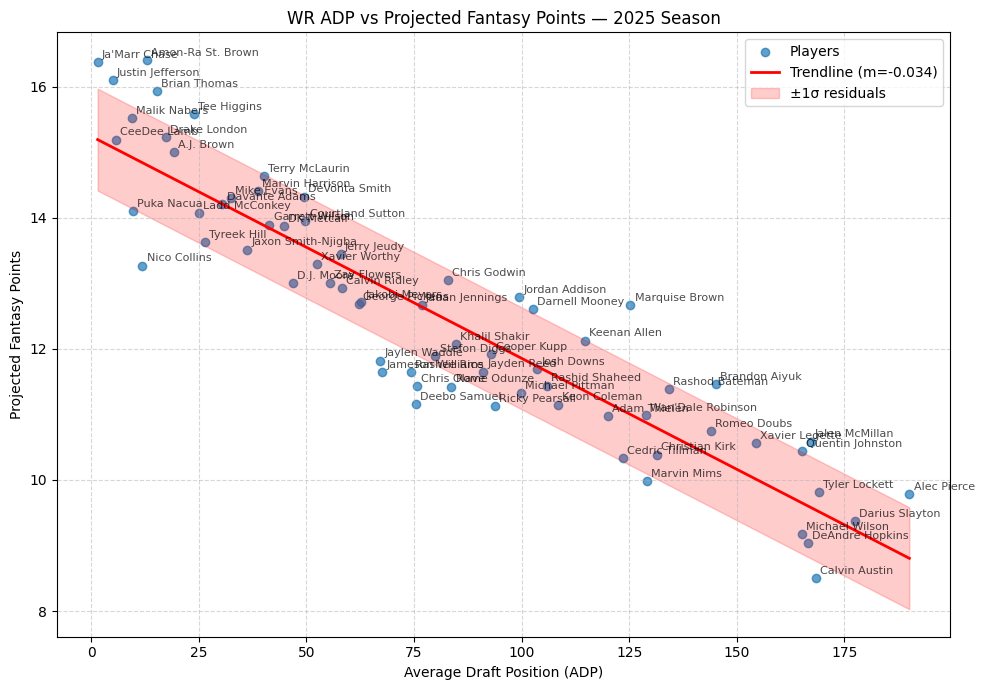

15.244831578422897


In [102]:
RB_2025.loc[RB_2025["player_name"] == "Amon-Ra St. Brown", "adp_for_rank"] = 13
RB_2025.loc[RB_2025["player_name"] == "A.J. Brown", "adp_for_rank"] = 19.2
RB_2025.loc[RB_2025["player_name"] == "D.J. Moore", "adp_for_rank"] = 46.8


xcol = "adp_for_rank"
ycol = "predicted_target_season"

## Include player_name in the dataframe
plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

# Clean as before
plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    # Annotate each point with player name
    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Projected Fantasy Points")
    plt.title("WR ADP vs Projected Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
print(b)

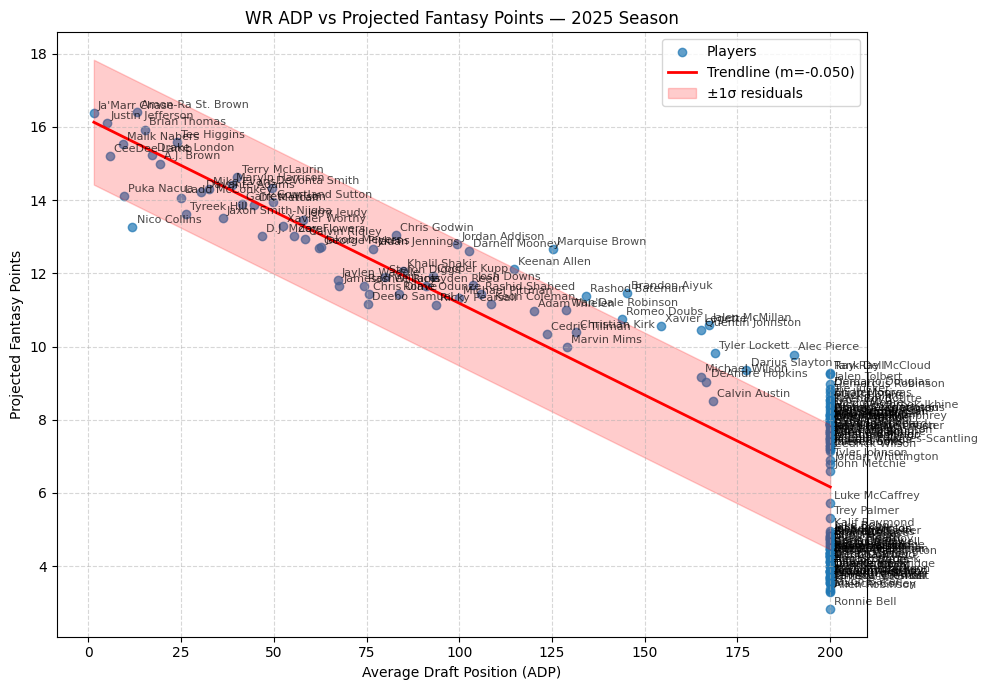

16.203924694714203


In [103]:
RB_2025["adp_for_rank"] = RB_2025["adp_for_rank"].fillna(200)
RB_2025.loc[RB_2025["player_name"] == "Amon-Ra St. Brown", "adp_for_rank"] = 13
RB_2025.loc[RB_2025["player_name"] == "A.J. Brown", "adp_for_rank"] = 19.2
RB_2025.loc[RB_2025["player_name"] == "D.J. Moore", "adp_for_rank"] = 46.8


xcol = "adp_for_rank"
ycol = "predicted_target_season"

## Include player_name in the dataframe
plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

# Clean as before
plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    # Annotate each point with player name
    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Projected Fantasy Points")
    plt.title("WR ADP vs Projected Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
print(b)